In [64]:
import time
import subprocess
import sys

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.losses import categorical_crossentropy

from tensorflow.keras.models import Model

from tensorflow.keras.layers import Cropping2D, Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [65]:
training_output = '/storage/brno2/home/sadovanh/segmentation_output'
training_date = '20240426'
num_classes = 15
epochs = 20
SIZE_X = 320
SIZE_Y = 320
SEED = 42

In [66]:
# Directories for the datasets
train_input_dir = "./segmentation/images_train"
test_input_dir = "./segmentation/images_test"
val_input_dir = "./segmentation/images_val"
train_mask_dir = "./segmentation/masks_train"
test_mask_dir = "./segmentation/masks_test"
val_mask_dir = "./segmentation/masks_val"

In [67]:
def load_images_from_directory(directory):
    local_images = []
    for filename in os.listdir(directory):
        full_path = os.path.join(directory, filename)  # Join directory and filename.
        image = cv2.imread(full_path, 0)  # Read the image in grayscale.
        if image is not None:  # Check if the image was loaded correctly.
            resized_image = cv2.resize(image, (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST)
            local_images.append(resized_image)
        else:
            print (f"Image {filename} was not loaded correctly")
    return local_images

In [68]:
# Loading train images
train_images = load_images_from_directory(train_input_dir)

train_images = np.array(train_images)

print(train_images.shape)

(2545, 320, 320)


In [69]:
# Validation images
val_images = load_images_from_directory(val_input_dir)

val_images = np.array(val_images)

print(val_images.shape)

(153, 320, 320)


In [70]:
# Train masks
train_masks = load_images_from_directory(train_mask_dir)

train_masks = np.array(train_masks)

print(train_masks.shape)
print(np.unique(train_masks))

(2545, 320, 320)
[  0  21  39  57  75  93 111 129 147 165 183 201 219 237 255]


In [71]:
# Validation masks
val_masks = load_images_from_directory(val_mask_dir)

val_masks = np.array(val_masks)

print(val_masks.shape)

(153, 320, 320)


In [72]:
def normalization(image):
    image = np.expand_dims(image, axis=3)
    image = normalize(image, axis=1)
    return image

In [73]:
train_images_normalized = normalization(train_images)
print(train_images_normalized.shape)

(2545, 320, 320, 1)


In [74]:
val_images_normalized = normalization(val_images)
print(val_images_normalized.shape)

(153, 320, 320, 1)


In [75]:
train_masks = np.expand_dims(train_masks, axis=3)
val_masks = np.expand_dims(val_masks, axis=3)

In [76]:
grayscale_to_class = {
    0: 0, 21: 1, 39: 2, 57: 3, 75: 4,
    93: 5, 111: 6, 129: 7, 147: 8, 165: 9,
    183: 10, 201: 11, 219: 12, 237: 13, 255: 14
}

In [77]:
def map_grayscale_to_class(value):
    if value in grayscale_to_class:
        return grayscale_to_class[value]
    else:
        # Handle unmapped values, for example, by returning a default class or raising an error
        raise ValueError(f"Unmapped grayscale value: {value}")

In [78]:
train_masks_class = np.vectorize(map_grayscale_to_class)(train_masks)
val_masks_class = np.vectorize(map_grayscale_to_class)(val_masks)

In [79]:
print(np.unique(train_masks_class))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [80]:
train_masks_cat = to_categorical(train_masks_class, num_classes=num_classes)
val_masks_cat = to_categorical(val_masks_class, num_classes=num_classes)

In [81]:
# Augmentation
data_gen_args = dict(
      rotation_range=180,
      shear_range=0.5,
      zoom_range=0.7,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='reflect')

In [82]:
image_data_generator = ImageDataGenerator(**data_gen_args)
mask_data_generator = ImageDataGenerator(**data_gen_args)

In [83]:
image_data_generator.fit(train_images_normalized, augment=True, seed=SEED)
image_generator = image_data_generator.flow(train_images_normalized, seed=SEED)
valid_img_generator = image_data_generator.flow(val_images_normalized, seed=SEED)

mask_data_generator.fit(train_masks_cat, augment=True, seed=SEED)
mask_generator = mask_data_generator.flow(train_masks_cat, seed=SEED)
valid_mask_generator = mask_data_generator.flow(val_masks_cat, seed=SEED)

In [84]:
train_generator = (pair for pair in zip(image_generator, mask_generator))
val_generator = (pair for pair in zip(valid_img_generator, valid_mask_generator))

In [85]:
def multi_unet_model(n_classes=15, IMG_HEIGHT=544, IMG_WIDTH=544, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs
    
    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [86]:
def get_model():
    return multi_unet_model(n_classes=num_classes, IMG_HEIGHT=SIZE_X, IMG_WIDTH=SIZE_Y, IMG_CHANNELS=1)

In [87]:
model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320, 320, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 320, 320, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 320, 320, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

                                                                                                  
 dropout_16 (Dropout)           (None, 160, 160, 32  0           ['conv2d_33[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_34 (Conv2D)             (None, 160, 160, 32  9248        ['dropout_16[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 320, 320, 16  2064       ['conv2d_34[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatena

In [88]:
batch_size = 8
steps_per_epoch=len(train_images)//batch_size
validation_steps=len(val_images)//batch_size

In [89]:
history = model.fit(train_generator,
                   batch_size = batch_size,
                   verbose=1,
                   epochs=100,
                   steps_per_epoch=steps_per_epoch, 
                   validation_data=val_generator,
                   validation_steps = validation_steps,
                   shuffle=False)

Epoch 1/20
318/318 [==============================] - 1457s 5s/step - loss: 0.9014 - accuracy: 0.8230 - val_loss: 0.7523 - val_accuracy: 0.8502
Epoch 2/20
318/318 [==============================] - 1450s 5s/step - loss: 0.7498 - accuracy: 0.8466 - val_loss: 0.7355 - val_accuracy: 0.8517
Epoch 3/20
318/318 [==============================] - 1451s 5s/step - loss: 0.7396 - accuracy: 0.8469 - val_loss: 0.7325 - val_accuracy: 0.8541
Epoch 4/20
318/318 [==============================] - 1441s 5s/step - loss: 0.7341 - accuracy: 0.8463 - val_loss: 0.6994 - val_accuracy: 0.8559
Epoch 5/20
318/318 [==============================] - 1447s 5s/step - loss: 0.7241 - accuracy: 0.8456 - val_loss: 0.6786 - val_accuracy: 0.8567
Epoch 6/20
318/318 [==============================] - 1418s 4s/step - loss: 0.7103 - accuracy: 0.8458 - val_loss: 0.6657 - val_accuracy: 0.8568
Epoch 7/20
318/318 [==============================] - 1417s 4s/step - loss: 0.6945 - accuracy: 0.8462 - val_loss: 0.6407 - val_accuracy:

In [238]:
tested_image_1 = './segmentation/images_train/0e8d3736396b615c0798033f37e4a481.png'
mask = './segmentation/masks_train/0e8d3736396b615c0798033f37e4a481.png'

In [239]:
def segment_image(model, img_path):
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, (SIZE_X, SIZE_Y), interpolation=cv2.INTER_NEAREST)
    img = np.array(img)

    img = np.expand_dims(img, axis=2)
    img = normalize(img, axis=1)

    img_norm = img[:,:,0][:,:,None]
    img_input=np.expand_dims(img_norm, 0)
    prediction=(model.predict(img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    
    return predicted_img

1/1 [==============================] - 0s 60ms/step


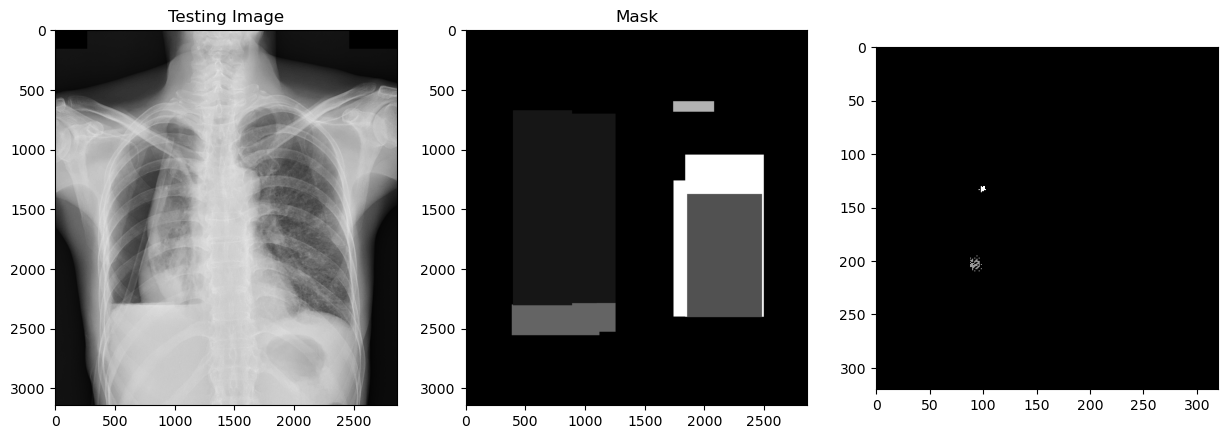

In [244]:
fig = plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(cv2.imread(tested_image_1, 0), cmap='gray')
plt.subplot(132)
plt.title('Mask')
plt.imshow(cv2.imread(mask, 0), cmap='gray')
plt.subplot(133)
plt.imshow(segment_image(model, tested_image_1), cmap='gray')

In [245]:
np.unique(segment_image(model, tested_image_1))

1/1 [==============================] - 0s 47ms/step


array([ 0,  6, 10])

In [242]:
np.unique(cv2.imread(mask, 0))

array([  0,  21,  75,  93, 165, 237], dtype=uint8)

In [95]:
model.save(f'model_{training_date}_last_big.h5')

In [243]:
model.save('model_20240427.h5')

In [36]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs=range(1, len(loss)+1)

# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss ')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.savefig(f'{training_output}/{training_date}_training_loss.png')
# plt.clf()

In [37]:
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']
# epochs=range(1, len(loss)+1)

# plt.plot(epochs, accuracy, 'y', label='Training accuracy')
# plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.savefig(f'{training_output}/{training_date}_training_accuracy.png')